In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import shap
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from scipy import stats

# Sklearn imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                           r2_score, accuracy_score, precision_score, 
                           recall_score, f1_score, classification_report,
                           roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification

# Other ML libraries
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.basicConfig(level=logging.WARNING)

In [114]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ
df = pd.read_csv('./data.csv')

In [116]:
df

Unnamed: 0    IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  \
0             0    6.239374  175.482382  28.125000           5.094096   
1             1    0.771831    5.402819   7.000000           3.961417   
2             2  223.808778  161.142320   0.720000           2.627117   
3             3    1.705624  107.855654  63.235294           5.097360   
4             4  107.131532  139.270991   1.300000           5.150510   
..          ...         ...         ...        ...                ...   
993         996   31.000104   34.999650   1.129017          12.934891   
994         997   31.999934   33.999415   1.062484          13.635345   
995         998   30.999883   33.999458   1.096761          13.991690   
996         999   31.998959   32.999644   1.031272          13.830180   
997        1000   99.999531   99.999531   1.000000          13.380863   

     MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0          5.094096           0.387225        0.387225  0.417362  42.928571   
1          3.961417           0.533868        0.533868  0.462473  45.214286   
2          2.627117           0.543231        0.543231  0.260923  42.187500   
3          5.097360           0.390603        0.390603  0.377846  41.862069   
4          5.150510           0.270476        0.270476  0.429038  36.514286   
..              ...                ...             ...       ...        ...   
993       12.934891           0.048029       -0.476142  0.382752  49.133333   
994       13.635345           0.030329       -0.699355  0.369425  44.542857   
995       13.991690           0.026535       -0.650790  0.284923  41.973684   
996       13.830180           0.146522       -1.408652  0.381559  39.000000   
997       13.380863           0.002425       -0.447978  0.452565  48.580645   

       MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0    384.652         340.300  384.350449                  158   
1    388.684         340.300  388.381750                  162   
2    446.808         388.344  446.458903                  186   
3    398.679         352.311  398.366099                  164   
4    466.713         424.377  466.334799                  184   
..       ...             ...         ...                  ...   
993  414.542         380.270  414.240624                  164   
994  485.621         446.309  485.277738                  192   
995  545.742         502.398  545.281109                  210   
996  522.635         480.299  522.282883                  208   
997  426.597         388.293  426.277010                  170   

     NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  \
0                      0          0.038844         -0.293526   
1                      0          0.012887         -0.313407   
2                      0          0.094802         -0.325573   
3                      0          0.038844         -0.293526   
4                      0          0.062897         -0.257239   
..                   ...               ...               ...   
993                    0          0.317890         -0.468587   
994                    0          0.327562         -0.467493   
995                    0          0.327887         -0.467485   
996                    0          0.312509         -0.468755   
997                    0          0.311311         -0.468587   

     MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  \
0               0.293526             0.038844          0.642857   
1               0.313407             0.012887          0.607143   
2               0.325573             0.094802          0.562500   
3               0.293526             0.038844          0.620690   
4               0.257239             0.062897          0.600000   
..                   ...                  ...               ...   
993             0.468587             0.317890          1.133333   
994             0.467493             0.327562          1.085714   
995             0.467485  

In [118]:
# –£–¥–∞–ª—è–µ–º –Ω–µ–º–Ω—Ñ–æ—Ä–º–∞—Ç–∏–≤–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫
df = df.drop(columns = ['Unnamed: 0'])


In [120]:
# –£–¥–∞–ª—è–µ–º –ø—Ä–æ–ø—É—Å–∫–∏
df = df.dropna()


In [122]:
# –£–¥–∞–ª—è–µ–º –¥—É–±–ª–∏–∫–∞—Ç—ã
df = df.drop_duplicates()


In [124]:
df.shape

(966, 213)

In [126]:
# –í—ã—á–∏—Å–ª—è–µ–º –º–µ–¥–∏–∞–Ω—É —Å—Ç–æ–ª–±—Ü–∞
median_value_ic50 = df['IC50, mM'].median()
median_value_cc50 = df['CC50, mM'].median()
median_value_si = df['SI'].median()


In [128]:
# –ü–æ–¥–≥–æ—Ç–∞–≤–ª–∏–≤–∞–µ–º —Ü–µ–ª–µ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
df['SI'] = (df['SI'] > 8).astype(int)
df['IC50, mM'] = (df['IC50, mM'] > median_value_ic50).astype(int)
df['CC50, mM'] = (df['CC50, mM'] > median_value_cc50).astype(int)


In [100]:
# –ü–æ–¥–≥–æ—Ç–∞–≤–ª–∏–≤–∞–µ–º –¥–∞–Ω–Ω—ã–µ –∏ —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é
X = df.drop(columns = ['IC50, mM', 'CC50, mM', 'SI'])
y = df['SI']


In [134]:
def detect_outliers(df, alpha=0.05, method='iqr', normality_test='shapiro', add_sum_column=False):
    """
    –û–±–Ω–∞—Ä—É–∂–µ–Ω–∏–µ –≤—ã–±—Ä–æ—Å–æ–≤ –≤ DataFrame —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —Ä–∞–∑–ª–∏—á–Ω—ã—Ö —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏—Ö –º–µ—Ç–æ–¥–æ–≤.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    df : pandas.DataFrame
        –í—Ö–æ–¥–Ω–æ–π DataFrame —Å –¥–∞–Ω–Ω—ã–º–∏ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞
    alpha : float, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 0.05
        –£—Ä–æ–≤–µ–Ω—å –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ –¥–ª—è —Ç–µ—Å—Ç–æ–≤ –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å
    method : str, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 'iqr'
        –ú–µ—Ç–æ–¥ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏—è –≤—ã–±—Ä–æ—Å–æ–≤ –¥–ª—è –Ω–µ–Ω–æ—Ä–º–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö:
        - 'iqr' - –º–µ—Ç–æ–¥ –º–µ–∂–∫–≤–∞—Ä—Ç–∏–ª—å–Ω–æ–≥–æ —Ä–∞–∑–º–∞—Ö–∞
        - 'zscore' - –º–æ–¥–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω—ã–π Z-score
    normality_test : str, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 'shapiro'
        –¢–µ—Å—Ç –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è:
        - 'shapiro' - —Ç–µ—Å—Ç –®–∞–ø–∏—Ä–æ-–£–∏–ª–∫–∞
        - 'normaltest' - —Ç–µ—Å—Ç –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å D'Agostino-Pearson
        - 'anderson' - —Ç–µ—Å—Ç –ê–Ω–¥–µ—Ä—Å–æ–Ω–∞-–î–∞—Ä–ª–∏–Ω–≥–∞
    add_sum_column : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é False
        –ï—Å–ª–∏ True, –¥–æ–±–∞–≤–ª—è–µ—Ç —Å—Ç–æ–ª–±–µ—Ü —Å –æ–±—â–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –≤—ã–±—Ä–æ—Å–æ–≤ –¥–ª—è –∫–∞–∂–¥–æ–π —Å—Ç—Ä–æ–∫–∏
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    pandas.DataFrame
        DataFrame —Å –±—É–ª–µ–≤—ã–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏, –≥–¥–µ True —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ –≤—ã–±—Ä–æ—Å
    """
    
    # –°–æ–∑–¥–∞–µ–º DataFrame –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é –≤—Å–µ –∑–Ω–∞—á–µ–Ω–∏—è False)
    outliers = pd.DataFrame(False, index=df.index, columns=df.columns)
    
    # –ê–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º –∫–∞–∂–¥—ã–π —Å—Ç–æ–ª–±–µ—Ü –æ—Ç–¥–µ–ª—å–Ω–æ
    for col in df.columns:
        # –£–¥–∞–ª—è–µ–º –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è —Ç–µ–∫—É—â–µ–≥–æ —Å—Ç–æ–ª–±—Ü–∞
        data = df[col].dropna()
        
        # –ï—Å–ª–∏ –≤ —Å—Ç–æ–ª–±—Ü–µ –º–µ–Ω—å—à–µ 3 –∑–Ω–∞—á–µ–Ω–∏–π, –ø—Ä–æ–ø—É—Å–∫–∞–µ–º –µ–≥–æ
        if len(data) < 3:
            continue
            
        # –ü—Ä–æ–≤–µ—Ä—è–µ–º –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
        normal = False  # –§–ª–∞–≥ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
        
        try:
            # –í—ã–±–∏—Ä–∞–µ–º —Ç–µ—Å—Ç –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä–∞ normality_test
            if normality_test == 'shapiro':
                # –¢–µ—Å—Ç –®–∞–ø–∏—Ä–æ-–£–∏–ª–∫–∞ (–ø–æ–¥—Ö–æ–¥–∏—Ç –¥–ª—è –Ω–µ–±–æ–ª—å—à–∏—Ö –≤—ã–±–æ—Ä–æ–∫ < 5000)
                _, p = stats.shapiro(data)
                normal = p > alpha  # –ï—Å–ª–∏ p-value > alpha, —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å—á–∏—Ç–∞–µ—Ç—Å—è –Ω–æ—Ä–º–∞–ª—å–Ω—ã–º
                
            elif normality_test == 'normaltest':
                # –¢–µ—Å—Ç D'Agostino-Pearson (—Ä–∞–±–æ—Ç–∞–µ—Ç –¥–ª—è –≤—ã–±–æ—Ä–æ–∫ > 20)
                _, p = stats.normaltest(data)
                normal = p > alpha
                
            elif normality_test == 'anderson':
                # –¢–µ—Å—Ç –ê–Ω–¥–µ—Ä—Å–æ–Ω–∞-–î–∞—Ä–ª–∏–Ω–≥–∞ (–±–æ–ª–µ–µ —Å—Ç—Ä–æ–≥–∏–π)
                result = stats.anderson(data)
                # –°—Ä–∞–≤–Ω–∏–≤–∞–µ–º —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É —Å –∫—Ä–∏—Ç–∏—á–µ—Å–∫–∏–º –∑–Ω–∞—á–µ–Ω–∏–µ–º –¥–ª—è –≤—ã–±—Ä–∞–Ω–Ω–æ–≥–æ alpha
                normal = result.statistic < result.critical_values[np.where(result.significance_level == int(alpha*100))[0][0]]
        except:
            # –í —Å–ª—É—á–∞–µ –æ—à–∏–±–∫–∏ –≤ —Ç–µ—Å—Ç–µ —Å—á–∏—Ç–∞–µ–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –Ω–µ–Ω–æ—Ä–º–∞–ª—å–Ω—ã–º
            pass
        
        # –ï—Å–ª–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ, –∏—Å–ø–æ–ª—å–∑—É–µ–º —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–π Z-score
        if normal:
            z = np.abs(stats.zscore(data))  # –í—ã—á–∏—Å–ª—è–µ–º Z-–æ—Ü–µ–Ω–∫–∏
            outliers.loc[data.index, col] = z > 3  # –í—ã–±—Ä–æ—Å—ã > 3 —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã—Ö –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–π
            
        # –î–ª—è –Ω–µ–Ω–æ—Ä–º–∞–ª—å–Ω—ã—Ö —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–π –∏—Å–ø–æ–ª—å–∑—É–µ–º –≤—ã–±—Ä–∞–Ω–Ω—ã–π –º–µ—Ç–æ–¥
        else:
            if method == 'iqr':
                # –ú–µ—Ç–æ–¥ –º–µ–∂–∫–≤–∞—Ä—Ç–∏–ª—å–Ω–æ–≥–æ —Ä–∞–∑–º–∞—Ö–∞ (IQR)
                q1 = data.quantile(0.25)  # –ü–µ—Ä–≤—ã–π –∫–≤–∞—Ä—Ç–∏–ª—å (25-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å)
                q3 = data.quantile(0.75)  # –¢—Ä–µ—Ç–∏–π –∫–≤–∞—Ä—Ç–∏–ª—å (75-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å)
                iqr = q3 - q1  # –ú–µ–∂–∫–≤–∞—Ä—Ç–∏–ª—å–Ω—ã–π —Ä–∞–∑–º–∞—Ö
                
                # –ì—Ä–∞–Ω–∏—Ü—ã –¥–ª—è –≤—ã–±—Ä–æ—Å–æ–≤
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                
                # –û—Ç–º–µ—á–∞–µ–º –≤—ã–±—Ä–æ—Å—ã
                outliers.loc[data.index, col] = (data < lower_bound) | (data > upper_bound)
                
            elif method == 'zscore':
                # –ú–æ–¥–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω—ã–π Z-score (–±–æ–ª–µ–µ —É—Å—Ç–æ–π—á–∏–≤—ã–π –∫ –≤—ã–±—Ä–æ—Å–∞–º)
                median = data.median()  # –ú–µ–¥–∏–∞–Ω–∞ –≤–º–µ—Å—Ç–æ —Å—Ä–µ–¥–Ω–µ–≥–æ
                mad = stats.median_abs_deviation(data, scale='normal')  # –ú–µ–¥–∏–∞–Ω–Ω–æ–µ –∞–±—Å–æ–ª—é—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ
                modified_z = np.abs(0.6745 * (data - median) / mad)  # –ú–æ–¥–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω—ã–π Z-score
                
                # –í—ã–±—Ä–æ—Å—ã –ø—Ä–∏ modified_z > 3.5
                outliers.loc[data.index, col] = modified_z > 3.5
    
    # –î–æ–±–∞–≤–ª—è–µ–º —Å—Ç–æ–ª–±–µ—Ü —Å —Å—É–º–º–æ–π –≤—ã–±—Ä–æ—Å–æ–≤ –ø–æ —Å—Ç—Ä–æ–∫–∞–º, –µ—Å–ª–∏ –Ω—É–∂–Ω–æ
    if add_sum_column:
        outliers['outliers_sum'] = outliers.sum(axis=1)
    
    return outliers




# –ù–∞—Ö–æ–¥–∏–º –≤—ã–±—Ä–æ—Å—ã
outliers = detect_outliers(df)

# –í—ã–≤–æ–¥–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤ –ø–æ –∫–∞–∂–¥–æ–º—É –ø—Ä–∏–∑–Ω–∞–∫—É
print("\n–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤ –ø–æ –ø—Ä–∏–∑–Ω–∞–∫–∞–º:")
print(outliers.sum())



–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤ –ø–æ –ø—Ä–∏–∑–Ω–∞–∫–∞–º:
IC50, mM              0
CC50, mM              0
SI                    0
MaxAbsEStateIndex    60
MaxEStateIndex       60
                     ..
fr_thiazole          52
fr_thiocyan           0
fr_thiophene         68
fr_unbrch_alkane     49
fr_urea               7
Length: 213, dtype: int64


üîç –û–±—É—á–µ–Ω–∏–µ Logistic Regression...
 Logistic Regression
Accuracy: 0.7113 | Precision: 0.7079 | Recall: 0.7113 | F1: 0.7093
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       125
           1       0.60      0.57      0.58        69

    accuracy                           0.71       194
   macro avg       0.68      0.68      0.68       194
weighted avg       0.71      0.71      0.71       194

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üîç –û–±—É—á–µ–Ω–∏–µ SVM...
 SVM
Accuracy: 0.7062 | Precision: 0.6945 | Recall: 0.7062 | F1: 0.6912
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       125
           1       0.62      0.43      0.51        69

    accuracy                           0.71       194
   macro avg       0.68      0.65      0.65       194
weighted avg    

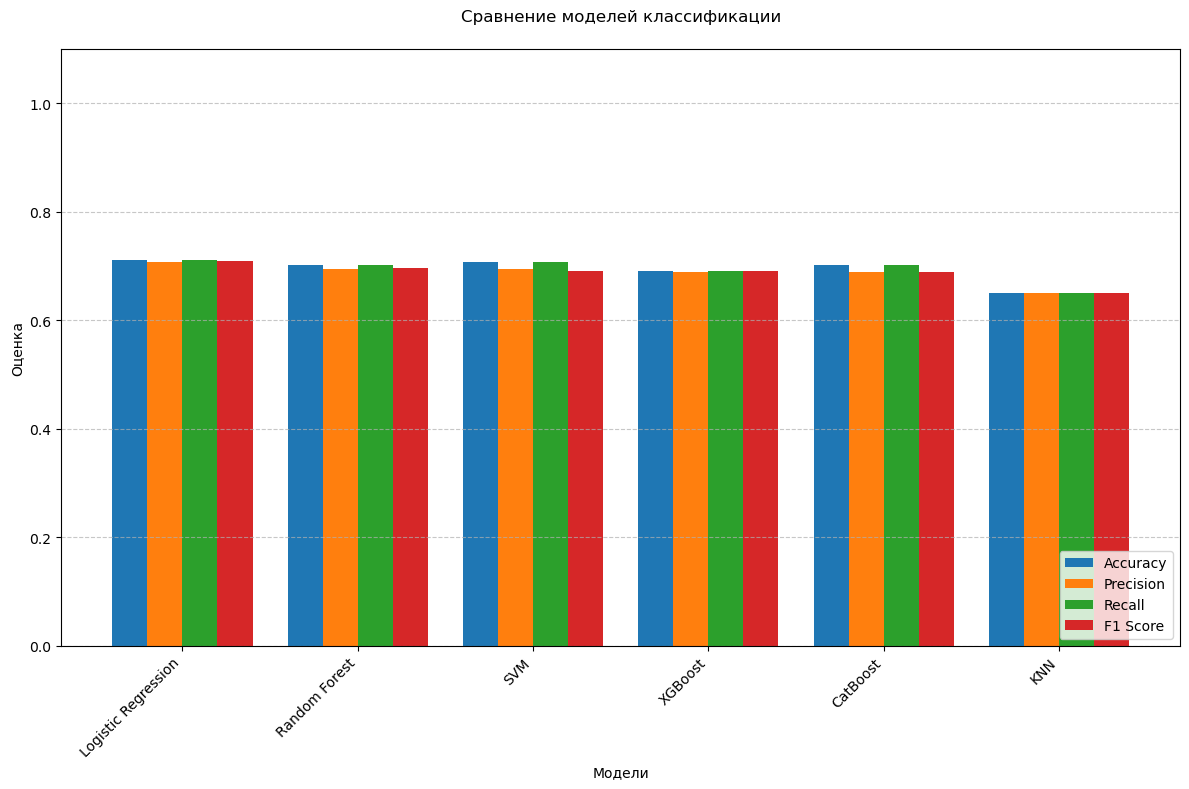

In [13]:

def test_classification_models_with_scaling(X, y, test_size=0.2, random_state=42, verbose=True):
    """
    –¢–µ—Å—Ç–∏—Ä—É–µ—Ç –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–æ–Ω–Ω—ã–µ –º–æ–¥–µ–ª–∏ —Å–æ —Å—Ç–∞–Ω–¥–∞—Ä—Ç–∏–∑–∞—Ü–∏–µ–π –¥–∞–Ω–Ω—ã—Ö –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã.

    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    X : pd.DataFrame –∏–ª–∏ np.array
        –ú–∞—Ç—Ä–∏—Ü–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    y : pd.Series –∏–ª–∏ np.array
        –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
    test_size : float, optional
        –†–∞–∑–º–µ—Ä —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 0.2)
    random_state : int, optional
        Seed –¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 42)
    verbose : bool, optional
        –í—ã–≤–æ–¥–∏—Ç—å –ª–∏ –ø—Ä–æ–≥—Ä–µ—Å—Å (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True)

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    pd.DataFrame
        –¢–∞–±–ª–∏—Ü–∞ —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏ –º–µ—Ç—Ä–∏–∫ –∏ –≤—Ä–µ–º–µ–Ω–µ–º –æ–±—É—á–µ–Ω–∏—è –¥–ª—è –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª–∏
    """

    # –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–µ–π —Å –ø–∞–π–ø–ª–∞–π–Ω–∞–º–∏ (StandardScaler + –º–æ–¥–µ–ª—å)
    models = {
        'Logistic Regression': make_pipeline(StandardScaler(),
                                           LogisticRegression(random_state=random_state, max_iter=1000)),
        'SVM': make_pipeline(StandardScaler(),
                            SVC(random_state=random_state)),
        'KNN': make_pipeline(StandardScaler(),
                            KNeighborsClassifier()),
        'Random Forest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=random_state, n_jobs=-1, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(random_state=random_state, verbose=False)
    }

    # –°–ª–æ–≤–∞—Ä—å –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    results = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Train Time (s)': [],
        'Scaler Used': []
    }

    # –û–±—É—á–µ–Ω–∏–µ –∏ –æ—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–µ–π
    for name, model in models.items():
        if verbose:
            print(f"üîç –û–±—É—á–µ–Ω–∏–µ {name}...")

        try:
            start_time = time.time()

            # –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
            model.fit(X_train, y_train)
            train_time = time.time() - start_time

            # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
            y_pred = model.predict(X_test)

            # –†–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è StandardScaler
            scaler_used = 'StandardScaler' if 'standardscaler' in str(model).lower() else 'No'

            # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
            results['Model'].append(name)
            results['Accuracy'].append(accuracy)
            results['Precision'].append(precision)
            results['Recall'].append(recall)
            results['F1 Score'].append(f1)
            results['Train Time (s)'].append(train_time)
            results['Scaler Used'].append(scaler_used)

            if verbose:
                print(f" {name}\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
                print(classification_report(y_test, y_pred))
                print("‚îÄ" * 50)

        except Exception as e:
            print(f" –û—à–∏–±–∫–∞ –≤ {name}: {str(e)}")
            continue

    # –°–æ–∑–¥–∞–Ω–∏–µ DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    results_df = pd.DataFrame(results).sort_values('F1 Score', ascending=False)

    # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    if verbose:
        plt.figure(figsize=(12, 8))
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        x = np.arange(len(results_df['Model']))
        width = 0.2

        for i, metric in enumerate(metrics):
            plt.bar(x + i*width, results_df[metric], width, label=metric)

        plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏', pad=20)
        plt.xlabel('–ú–æ–¥–µ–ª–∏')
        plt.ylabel('–û—Ü–µ–Ω–∫–∞')
        plt.xticks(x + width*1.5, results_df['Model'], rotation=45, ha='right')
        plt.ylim(0, 1.1)
        plt.legend(loc='lower right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    return results_df


# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results = test_classification_models_with_scaling(X, y)

In [14]:
# –ò—â–µ–º –Ω–∞–∏–ª—É—á—à–∏–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –ø–æ–≤—ã—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏

def evaluate_model(X, y, model, test_size=0.2, random_state=42):
    """–§—É–Ω–∫—Ü–∏—è –æ—Ü–µ–Ω–∫–∏ –º–æ–¥–µ–ª–∏ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Å –¥–æ–±–∞–≤–ª–µ–Ω–∏–µ–º StandardScaler"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # –î–ª—è –º–æ–¥–µ–ª–µ–π, —á—É–≤—Å—Ç–≤–∏—Ç–µ–ª—å–Ω—ã—Ö –∫ –º–∞—Å—à—Ç–∞–±—É, –∏—Å–ø–æ–ª—å–∑—É–µ–º Pipeline —Å–æ StandardScaler
    if isinstance(model, (LogisticRegression, SVC, KNeighborsClassifier)):
        model = make_pipeline(StandardScaler(), model)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

def find_best_feature_subset(X, y, model, model_name):
    """–ú–æ–¥–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –≤–µ—Ä—Å–∏—è –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Å —É–∫–∞–∑–∞–Ω–∏–µ–º –∏–º–µ–Ω–∏ –º–æ–¥–µ–ª–∏"""
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    current_features = X.columns.tolist()
    initial_scores = evaluate_model(X[current_features], y, model)
    best_f1 = initial_scores['f1']
    best_accuracy = initial_scores['accuracy']
    best_features = current_features.copy()
    history = []

    history.append({
        'features': current_features.copy(),
        'f1': best_f1,
        'accuracy': best_accuracy,
        'action': 'initial'
    })

    print(f"\n=== {model_name} ===")
    print(f"Initial F1: {best_f1:.4f}, Accuracy: {best_accuracy:.4f} with {len(current_features)} features")

    improved = True
    while improved and len(current_features) > 1:
        improved = False
        worst_feature = None

        for feature in current_features:
            trial_features = [f for f in current_features if f != feature]
            current_scores = evaluate_model(X[trial_features], y, model)

            history.append({
                'features': trial_features.copy(),
                'f1': current_scores['f1'],
                'accuracy': current_scores['accuracy'],
                'action': f'removed {feature}'
            })

            if current_scores['f1'] > best_f1:
                best_f1 = current_scores['f1']
                best_accuracy = current_scores['accuracy']
                best_features = trial_features.copy()
                worst_feature = feature
                improved = True

        if improved:
            current_features.remove(worst_feature)

    print(f"Best F1: {best_f1:.4f}, Accuracy: {best_accuracy:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)

    return {
        'model': model_name,
        'best_f1': best_f1,
        'best_accuracy': best_accuracy,
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'without selection'
    }

def test_all_models(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–æ–Ω–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π –ø–æ –æ—á–µ—Ä–µ–¥–∏"""
    # –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª–∏ —Å –¥–µ—Ñ–æ–ª—Ç–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
    models = [
        ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
        ('SVM', SVC(random_state=42)),
        ('KNN', KNeighborsClassifier()),
        ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('XGBoost', XGBClassifier(random_state=42, eval_metric='logloss')),
        ('CatBoost', CatBoostClassifier(silent=True, random_state=42))
    ]

    results = []

    for name, model in models:
        try:
            result = find_best_feature_subset(X, y, model, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue

    # –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    results_df = pd.DataFrame(results)

    return results_df

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞:
results_col_combination = test_all_models(X, y)


=== LogisticRegression ===
Initial F1: 0.7093, Accuracy: 0.7113 with 210 features
Best F1: 0.7232, Accuracy: 0.7268 with 208 features
Optimal features: ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_V

In [136]:
# –ò—â–µ–º –Ω–∞–∏–ª—É—á—à–∏–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –ø–æ–≤—ã—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏, —á–µ—Ä–µ–∑ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ–µ —É–¥–∞–ª–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤, —É–ø–æ—Ä—è–¥–æ—á–µ–Ω–Ω—ã—Ö –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –≤–æ–∑–º–æ–∂–Ω—ã—Ö –≤—ã–±—Ä–æ—Å–æ–≤
outliers_count = pd.DataFrame({
        'feature': df.columns,
        'outliers': outliers.sum(axis=0)
    }).sort_values('outliers', ascending=False)
all_features_outliers = outliers_count['feature'][outliers_count['outliers']>0].tolist()


def test_all_models(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–æ–Ω–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π"""
    models = [
        ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
        ('SVM', SVC(probability=True, random_state=42)),
        ('KNN', KNeighborsClassifier()),
        ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('XGBoost', XGBClassifier(random_state=42, eval_metric='logloss')),
        ('CatBoost', CatBoostClassifier(silent=True, random_state=42))
    ]

    results = []

    for name, model in models:
        try:
            result = get_best_features(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue

    return pd.DataFrame(results)

def get_best_features(X, y, model_name):
    """
    –û—Ç–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å —É–¥–∞–ª–µ–Ω–∏–µ–º –≤—ã–±—Ä–æ—Å–æ–≤ –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    - best_features: —Å–ø–∏—Å–æ–∫ –ª—É—á—à–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    - best_metrics: –ª—É—á—à–∏–µ –º–µ—Ç—Ä–∏–∫–∏
    """
    best_metrics = {
        'accuracy': 0,
        'f1': 0,
        'roc_auc': 0
    }
    best_features = []
    removed = []
    # –ü–µ—Ä–µ–±–∏—Ä–∞–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–¥–∞–ª—è–µ–º—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å –≤—ã–±—Ä–æ—Å–∞–º–∏
    for n in range(1, len(all_features_outliers)+1):
        
        current_features = X.drop(columns = all_features_outliers[:n]).columns.tolist()

        metrics = evaluate_metrics(X[current_features], y, model_name)

        if metrics['f1'] > best_metrics['f1']:
            best_metrics = metrics
            best_features = current_features.copy()
            removed = all_features_outliers[:n]
    print(f"\n=== {model_name} ===")
    print(f"Best Metrics: {best_metrics}")
    print(f"Selected features: {len(best_features)} (Removed {len(removed)} outliers)")
    return {
        'model': model_name,
        'best_f1': best_metrics['f1'],
        'best_accuracy': best_metrics['accuracy'],
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'outliers'
    }
   

def evaluate_metrics(X, y, model_name):
    """
    –û—Ü–µ–Ω–∫–∞ –º–µ—Ç—Ä–∏–∫ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏
    """
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': make_pipeline(StandardScaler(), SVC(probability=True, random_state=42)),
        'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(silent=True, random_state=42)
    }

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    model = models[model_name]
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

    if y_proba is not None and len(np.unique(y)) == 2:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
    else:
        metrics['roc_auc'] = None

    return metrics

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_col_combination_2 = test_all_models(X, y)


=== LogisticRegression ===
Best Metrics: {'accuracy': 0.7525773195876289, 'f1': 0.7391208883126659, 'roc_auc': 0.6892753623188406}
Selected features: 89 (Removed 121 outliers)

=== SVM ===
Best Metrics: {'accuracy': 0.7422680412371134, 'f1': 0.7358973494174564, 'roc_auc': 0.689159420289855}
Selected features: 44 (Removed 166 outliers)

=== KNN ===
Best Metrics: {'accuracy': 0.6958762886597938, 'f1': 0.6943002413195152, 'roc_auc': 0.6894492753623188}
Selected features: 32 (Removed 178 outliers)

=== RandomForest ===
Best Metrics: {'accuracy': 0.7164948453608248, 'f1': 0.711530895899153, 'roc_auc': 0.7195362318840579}
Selected features: 170 (Removed 40 outliers)

=== XGBoost ===
Best Metrics: {'accuracy': 0.7164948453608248, 'f1': 0.711530895899153, 'roc_auc': 0.7284637681159419}
Selected features: 151 (Removed 59 outliers)

=== CatBoost ===
Best Metrics: {'accuracy': 0.7216494845360825, 'f1': 0.7147691373708529, 'roc_auc': 0.7211014492753623}
Selected features: 31 (Removed 179 outliers

In [16]:
# –ò—â–µ–º –Ω–∞–∏–ª—É—á—à–∏–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å —É—á–µ—Ç–æ–º –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö —Å –ø–æ–º–æ—â—å—é SHAP

def test_tree_models_sh(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Å SHAP-–∞–Ω–∞–ª–∏–∑–æ–º"""
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "CatBoost": CatBoostClassifier(silent=True, random_state=42),
    }

    results = []

    for name, model in models.items():
        try:
            result = get_shap_selection(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue

    return pd.DataFrame(results)

def get_shap_selection(X, y, name):
    """
    –û—Ç–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å –ø–æ–º–æ—â—å—é SHAP –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    - best_features: —Å–ø–∏—Å–æ–∫ –ª—É—á—à–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    - best_metrics: –ª—É—á—à–∏–µ –º–µ—Ç—Ä–∏–∫–∏
    - all_features: –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –ø–æ –≤–∞–∂–Ω–æ—Å—Ç–∏
    """
    feature_names = X.columns.tolist()

    if name == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
    elif name == 'XGBoost':
        model = XGBRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
    elif name == 'CatBoost':
        model = CatBoostRegressor(
        iterations=100,
        random_seed=42,
        verbose=False
        )
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
   
    feat_importance = pd.DataFrame({
        'feature': importance['feature'],
        'importance': importance['mean_abs_shap']
    }).sort_values('importance', ascending=False)
    
    all_features = feat_importance['feature'][feat_importance['importance']>0].tolist()
    
    
    # –ù–∞—Ö–æ–¥–∏–º –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    best_metrics = {
        'accuracy': 0,
        'f1': 0,
        'roc_auc': 0
    }
    best_features = []

    for n in range(1, min(20, len(all_features)+1)):  # –û–≥—Ä–∞–Ω–∏—á–∏–≤–∞–µ–º –¥–æ 20 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è —Å–∫–æ—Ä–æ—Å—Ç–∏
        current_features = all_features[:n]
        current_metrics = evaluate_classification_metrics(X[current_features], y, name)

        if current_metrics['f1'] > best_metrics['f1']:
            best_metrics = current_metrics
            best_features = current_features.copy()

    print(f"\n=== {name} ===")
    print(f"Best Metrics: Accuracy={best_metrics['accuracy']:.4f}, F1={best_metrics['f1']:.4f}, ROC-AUC={best_metrics.get('roc_auc', 'N/A')}")
    print(f"Optimal features ({len(best_features)}): {best_features[:5]}...")  # –ü–æ–∫–∞–∑—ã–≤–∞–µ–º –ø–µ—Ä–≤—ã–µ 5 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

    return {
        'model': name,
        'best_f1': best_metrics['f1'],
        'best_accuracy': best_metrics['accuracy'],
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'shap'
    }

def evaluate_classification_metrics(X, y, model_name, test_size=0.2, random_state=42):
    """
    –û—Ü–µ–Ω–∫–∞ –º–µ—Ç—Ä–∏–∫ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏
    """
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "CatBoost": CatBoostClassifier(silent=True, random_state=42),
    }

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    model = models[model_name]
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

    if y_proba is not None and len(np.unique(y)) == 2:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)

    return metrics

def get_significant_shap_features(shap_values, feature_names, threshold=0):
    """
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –ø–æ —É–±—ã–≤–∞–Ω–∏—é —Å–ø–∏—Å–æ–∫ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å SHAP-–∑–Ω–∞—á–∏–º–æ—Å—Ç—å—é

    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    shap_values : shap.Explanation –∏–ª–∏ np.ndarray
        SHAP –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è –≤—Å–µ—Ö –Ω–∞–±–ª—é–¥–µ–Ω–∏–π
    feature_names : list –∏–ª–∏ pd.Index
        –°–ø–∏—Å–æ–∫ –Ω–∞–∑–≤–∞–Ω–∏–π –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    threshold : float, optional
        –ü–æ—Ä–æ–≥ –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 0)

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    pd.DataFrame: DataFrame —Å –∫–æ–ª–æ–Ω–∫–∞–º–∏ 'feature' –∏ 'mean_abs_shap',
                  –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –ø–æ —É–±—ã–≤–∞–Ω–∏—é –≤–∞–∂–Ω–æ—Å—Ç–∏
    """
    if isinstance(shap_values, shap.Explanation):
        shap_array = shap_values.values
    else:
        shap_array = shap_values

    # –î–ª—è –º–Ω–æ–≥–æ–∫–ª–∞—Å—Å–æ–≤–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –±–µ—Ä–µ–º —Å—Ä–µ–¥–Ω–µ–µ –ø–æ –≤—Å–µ–º –∫–ª–∞—Å—Å–∞–º
    if len(shap_array.shape) == 3:
        mean_abs_shap = np.abs(shap_array).mean(axis=(0, 1))
    else:
        mean_abs_shap = np.abs(shap_array).mean(axis=0)

    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    })

    significant_features = shap_importance[shap_importance['mean_abs_shap'] > threshold] \
        .sort_values('mean_abs_shap', ascending=False)
    
    return significant_features.reset_index(drop=True)

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_col_combination_3 = test_tree_models_sh(X, y)


=== RandomForest ===
Best Metrics: Accuracy=0.7216, F1=0.7174, ROC-AUC=0.7188405797101449
Optimal features (15): ['BCUT2D_MRLOW', 'FractionCSP3', 'BCUT2D_LOGPHI', 'SMR_VSA7', 'VSA_EState8']...

=== XGBoost ===
Best Metrics: Accuracy=0.7165, F1=0.7160, ROC-AUC=0.744
Optimal features (18): ['FractionCSP3', 'BCUT2D_MRLOW', 'VSA_EState5', 'BCUT2D_LOGPHI', 'BCUT2D_CHGLO']...

=== CatBoost ===
Best Metrics: Accuracy=0.7371, F1=0.7270, ROC-AUC=0.7642898550724638
Optimal features (18): ['BCUT2D_MRLOW', 'RingCount', 'NumSaturatedCarbocycles', 'SlogP_VSA6', 'Chi1']...


In [17]:
# –ò—â–µ–º –Ω–∞–∏–ª—É—á—à–∏–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å —É—á–µ—Ç–æ–º –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö —Å –ø–æ–º–æ—â—å—é features importance

def test_tree_models_fs(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Å –æ—Ç–±–æ—Ä–æ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤"""
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "CatBoost": CatBoostClassifier(silent=True, random_state=42),
    }
    
    results = []
    
    for name, model in models.items():
        try:
            result = get_feature_selection(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    return pd.DataFrame(results)

def get_feature_selection(X, y, name):
    """
    –û—Ç–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    - best_features: —Å–ø–∏—Å–æ–∫ –ª—É—á—à–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    - best_metrics: –ª—É—á—à–∏–µ –º–µ—Ç—Ä–∏–∫–∏
    - all_features: –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –ø–æ –≤–∞–∂–Ω–æ—Å—Ç–∏
    """
    feature_names = X.columns.tolist()
    
    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∏ –æ–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
    if name == 'RandomForest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif name == 'XGBoost':
        model = XGBClassifier(random_state=42, eval_metric='logloss')
    elif name == 'CatBoost':
        model = CatBoostClassifier(iterations=100, random_seed=42, verbose=False)
    
    model.fit(X, y)
    
    # –ü–æ–ª—É—á–µ–Ω–∏–µ –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    if name == 'XGBoost':
        importance = model.feature_importances_
    else:
        importance = model.feature_importances_
    
    # –°–æ—Ä—Ç–∏—Ä–æ–≤–∫–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –≤–∞–∂–Ω–æ—Å—Ç–∏
    feat_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    all_features = feat_importance['feature'].tolist()
    
    # –ü–æ–∏—Å–∫ –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ –Ω–∞–±–æ—Ä–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    best_metrics = {
        'accuracy': 0,
        'f1': 0,
        'roc_auc': 0
    }
    best_features = []
    
    # –û–≥—Ä–∞–Ω–∏—á–∏–≤–∞–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–≤–µ—Ä—è–µ–º—ã—Ö –∫–æ–º–±–∏–Ω–∞—Ü–∏–π –¥–ª—è —Å–∫–æ—Ä–æ—Å—Ç–∏
    max_features_to_test = min(20, len(all_features))
    
    for n in range(1, max_features_to_test + 1):
        current_features = all_features[:n]
        current_metrics = evaluate_classification_metrics(X[current_features], y, name)
        
        if current_metrics['f1'] > best_metrics['f1']:
            best_metrics = current_metrics
            best_features = current_features.copy()
    
    print(f"\n=== {name} ===")
    print(f"Best Metrics: Accuracy={best_metrics['accuracy']:.4f}, F1={best_metrics['f1']:.4f}, ROC-AUC={best_metrics.get('roc_auc', 'N/A')}")
    print(f"Optimal features ({len(best_features)}): {best_features[:5]}...")  # –ü–æ–∫–∞–∑—ã–≤–∞–µ–º –ø–µ—Ä–≤—ã–µ 5 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

    return {
        'model': name,
        'best_f1': best_metrics['f1'],
        'best_accuracy': best_metrics['accuracy'],
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'feature_importance'
    }
    

def evaluate_classification_metrics(X, y, model_name, test_size=0.2, random_state=42):
    """
    –û—Ü–µ–Ω–∫–∞ –º–µ—Ç—Ä–∏–∫ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏
    """
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "CatBoost": CatBoostClassifier(silent=True, random_state=42),
    }
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=y
    )
    
    model = models[model_name]
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    
    if y_proba is not None and len(np.unique(y)) == 2:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
    
    return metrics

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_col_combination_4  = test_tree_models_fs(X, y)


=== RandomForest ===
Best Metrics: Accuracy=0.7165, F1=0.7128, ROC-AUC=0.7172753623188406
Optimal features (20): ['VSA_EState4', 'SMR_VSA7', 'BCUT2D_CHGLO', 'BertzCT', 'BCUT2D_MRLOW']...

=== XGBoost ===
Best Metrics: Accuracy=0.7062, F1=0.7047, ROC-AUC=0.7442318840579709
Optimal features (17): ['fr_halogen', 'fr_allylic_oxid', 'SMR_VSA1', 'NHOHCount', 'fr_Al_OH']...

=== CatBoost ===
Best Metrics: Accuracy=0.7320, F1=0.7209, ROC-AUC=0.7308985507246376
Optimal features (10): ['PEOE_VSA8', 'FractionCSP3', 'MaxAbsEStateIndex', 'SlogP_VSA5', 'SMR_VSA7']...


In [18]:
# –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å–µ –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
results_df = pd.concat([results_col_combination,results_col_combination_2, results_col_combination_3, results_col_combination_4], ignore_index = True)

In [19]:
results_df

model   best_f1  best_accuracy  \
0   LogisticRegression  0.723226       0.726804   
1                  SVM  0.728251       0.742268   
2                  KNN  0.704280       0.701031   
3         RandomForest  0.717400       0.721649   
4              XGBoost  0.740451       0.742268   
5             CatBoost  0.705605       0.716495   
6   LogisticRegression  0.685939       0.695876   
7                  SVM  0.706511       0.721649   
8                  KNN  0.661820       0.659794   
9         RandomForest  0.699653       0.706186   
10             XGBoost  0.689675       0.690722   
11            CatBoost  0.694899       0.706186   
12        RandomForest  0.717400       0.721649   
13             XGBoost  0.716025       0.716495   
14            CatBoost  0.727015       0.737113   
15        RandomForest  0.712781       0.716495   
16             XGBoost  0.704663       0.706186   
17            CatBoost  0.720857       0.731959   

                                        best_features  num_features  \
0   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           208   
1   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           206   
2   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           205   
3   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           209   
4   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           205   
5   [MaxAbsEStateIndex, MaxEStateIndex, MinEStateI...           208   
6   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           195   
7   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           198   
8   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           193   
9   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           206   
10  [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           210   
11  [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           204   
12  [BCUT2D_MRLOW, FractionCSP3, BCUT2D_LOGPHI, SM...            15   
13  [FractionCSP3, BCUT2D_MRLOW, VSA_EState5, BCUT...            18   
14  [BCUT2D_MRLOW, RingCount, NumSaturatedCarbocyc...            18   
15  [VSA_EState4, SMR_VSA7, BCUT2D_CHGLO, BertzCT,...            20   
16  [fr_halogen, fr_allylic_oxid, SMR_VSA1, NHOHCo...            17   
17  [PEOE_VSA8, FractionCSP3, MaxAbsEStateIndex, S...            10   

              selector  
0    without selection  
1    without selection  
2    without selection  
3    without selection  
4    without selection  
5    without selection  
6             outliers  
7             outliers  
8             outliers  
9             outliers  
10            outliers  
11            outliers  
12                shap  
13                shap  
14                shap  
15  feature_importance  
16  feature_importance  
17  feature_importance

In [20]:

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –Ω–∞–ª—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç —Ä–∞–±–æ—Ç—ã –º–æ–¥–µ–ª–µ–π
def test_all_classifiers(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–æ–≤"""
    models = [
        ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
        ('SVM', SVC(probability=True, random_state=42)),
        ('KNN', KNeighborsClassifier()),
        ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('XGBoost', XGBClassifier(random_state=42, eval_metric='logloss')),
        ('CatBoost', CatBoostClassifier(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = evaluate_classifier(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    return pd.DataFrame(results)

def evaluate_classifier(X, y, model_name):
    """
    –û—Ü–µ–Ω–∫–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ —Å –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–º –Ω–∞–±–æ—Ä–æ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    - best_features: —Å–ø–∏—Å–æ–∫ –ª—É—á—à–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    - best_metrics: –ª—É—á—à–∏–µ –º–µ—Ç—Ä–∏–∫–∏
    """
    # –ù–∞—Ö–æ–¥–∏–º –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏
    best_metrics = {
        'accuracy': 0,
        'f1': 0,
        'roc_auc': 0
    }
    best_features = []
    
    # –ü–æ–ª—É—á–∞–µ–º –≤—Å–µ –Ω–∞–±–æ—Ä—ã –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏–∑ –ø—Ä–µ–¥—ã–¥—É—â–∏—Ö —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    feature_sets = [set(features) for features in results_df['best_features']]
    
    # –î–æ–±–∞–≤–ª—è–µ–º –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è
    feature_sets.append(set(X.columns))
    
    # –£–¥–∞–ª—è–µ–º –¥—É–±–ª–∏–∫–∞—Ç—ã
    unique_feature_sets = []
    seen = set()
    for fs in feature_sets:
        frozen = frozenset(fs)
        if frozen not in seen:
            seen.add(frozen)
            unique_feature_sets.append(list(fs))
    
    for current_features in unique_feature_sets:
        current_metrics = get_classification_metrics(X[current_features], y, model_name)
        
        if current_metrics['f1'] > best_metrics['f1']:
            best_metrics = current_metrics
            best_features = current_features.copy()
    
    print(f"\n=== {model_name} ===")
    print(f"Best Metrics: Accuracy={best_metrics['accuracy']:.4f}, F1={best_metrics['f1']:.4f}, ROC-AUC={best_metrics.get('roc_auc', 'N/A')}")
    print(f"Optimal features ({len(best_features)}): {best_features[:5]}...")

    return {
        'model': model_name,
        'best_f1': best_metrics['f1'],
        'best_accuracy': best_metrics['accuracy'],
        'best_features': best_features,
        'num_features': len(best_features)
        
    }
    

def get_classification_metrics(X, y, model_name, test_size=0.2, random_state=42):
    """
    –û—Ü–µ–Ω–∫–∞ –º–µ—Ç—Ä–∏–∫ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏
    """
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': make_pipeline(StandardScaler(), SVC(probability=True, random_state=42)),
        'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(silent=True, random_state=42)
    }
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=y
    )
    
    model = models[model_name]
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    
    if y_proba is not None and len(np.unique(y)) == 2:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
    
    return metrics

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_features_selection  = test_all_classifiers(X, y)


=== LogisticRegression ===
Best Metrics: Accuracy=0.7216, F1=0.6954, ROC-AUC=0.6672463768115942
Optimal features (18): ['SlogP_VSA6', 'Chi2n', 'EState_VSA8', 'VSA_EState4', 'SMR_VSA6']...

=== SVM ===
Best Metrics: Accuracy=0.7732, F1=0.7609, ROC-AUC=0.7349565217391305
Optimal features (18): ['SlogP_VSA6', 'Chi2n', 'EState_VSA8', 'VSA_EState4', 'SMR_VSA6']...

=== KNN ===
Best Metrics: Accuracy=0.7165, F1=0.7150, ROC-AUC=0.7083478260869565
Optimal features (18): ['SlogP_VSA6', 'Chi2n', 'EState_VSA8', 'VSA_EState4', 'SMR_VSA6']...

=== RandomForest ===
Best Metrics: Accuracy=0.7320, F1=0.7266, ROC-AUC=0.7361159420289856
Optimal features (18): ['FractionCSP3', 'VSA_EState5', 'EState_VSA8', 'MinPartialCharge', 'MinAbsEStateIndex']...

=== XGBoost ===
Best Metrics: Accuracy=0.7371, F1=0.7325, ROC-AUC=0.7254492753623187
Optimal features (10): ['FractionCSP3', 'MinPartialCharge', 'SMR_VSA6', 'fr_Imine', 'MaxAbsEStateIndex']...

=== CatBoost ===
Best Metrics: Accuracy=0.7371, F1=0.7270, ROC-

In [21]:
results_features_selection

model   best_f1  best_accuracy  \
0  LogisticRegression  0.695427       0.721649   
1                 SVM  0.760861       0.773196   
2                 KNN  0.715026       0.716495   
3        RandomForest  0.726643       0.731959   
4             XGBoost  0.732510       0.737113   
5            CatBoost  0.727015       0.737113   

                                       best_features  num_features  
0  [SlogP_VSA6, Chi2n, EState_VSA8, VSA_EState4, ...            18  
1  [SlogP_VSA6, Chi2n, EState_VSA8, VSA_EState4, ...            18  
2  [SlogP_VSA6, Chi2n, EState_VSA8, VSA_EState4, ...            18  
3  [FractionCSP3, VSA_EState5, EState_VSA8, MinPa...            18  
4  [FractionCSP3, MinPartialCharge, SMR_VSA6, fr_...            10  
5  [FractionCSP3, MinPartialCharge, SMR_VSA6, fr_...            10

In [22]:

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –ª—É—á—à—É—é –∫–æ–º–±–∏–Ω–∞—Ü–∏—é —Å—Ç—Ä–æ–∫ –¥–ª—è –ø–æ–≤—ã—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ —Ä–∞–±–æ—Ç—ã –º–æ–¥–µ–ª–µ–π –Ω–∞ –≤—Å–µ—Ö –¥–∞–Ω–Ω—ã—Ö
def test_all_classifiers_optimized(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–æ–≤ —Å –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–µ–π –Ω–∞–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö"""
    models = [
        ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
        ('SVM', SVC(probability=True, random_state=42)),
        ('KNN', KNeighborsClassifier()),
        ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('XGBoost', XGBClassifier(random_state=42, eval_metric='logloss')),
        ('CatBoost', CatBoostClassifier(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = optimize_classifier_data(X, y, name, model)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    return pd.DataFrame(results)

def optimize_classifier_data(X, y, name, model, verbose=True):
    """
    –û–ø—Ç–∏–º–∏–∑–∏—Ä—É–µ—Ç –Ω–∞–±–æ—Ä –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ –ø—É—Ç–µ–º –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ–≥–æ —É–¥–∞–ª–µ–Ω–∏—è —Å—Ç—Ä–æ–∫
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    X : pd.DataFrame
        –ü—Ä–∏–∑–Ω–∞–∫–∏
    y : pd.Series
        –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
    name : str
        –ò–º—è –º–æ–¥–µ–ª–∏
    model : sklearn classifier
        –ú–æ–¥–µ–ª—å –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞
    verbose : bool
        –í—ã–≤–æ–¥–∏—Ç—å –ª–∏ –ø—Ä–æ–≥—Ä–µ—Å—Å
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    dict: –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏
    """
    # –ò—Å–ø–æ–ª—å–∑—É–µ–º –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è –º–æ–¥–µ–ª–∏
    models = {
        'LogisticRegression': make_pipeline(StandardScaler(),LogisticRegression(max_iter=1000, random_state=42)),
        'SVM': make_pipeline(StandardScaler(), SVC(probability=True, random_state=42)),
        'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(silent=True, random_state=42)
    }
    if name == 'LogisticRegression':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][0]]
        
    elif name == 'SVM':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][1]]
        
    elif name == 'KNN':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][2]]
    elif name == 'RandomForest':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][3]]
    elif name == 'XGBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][4]]
    elif name == 'CatBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][5]]
    
    
    # –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö —Å–æ —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏–µ–π
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )
    
    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è
    X_opt = X_train.copy()
    y_opt = y_train.copy()
    best_metrics = {
        'accuracy': 0,
        'f1': 0,
        'roc_auc': 0
    }
    removed_indices = []
    
    # –ü—Ä–æ–≥—Ä–µ—Å—Å-–±–∞—Ä –¥–ª—è –Ω–∞–≥–ª—è–¥–Ω–æ—Å—Ç–∏
    iterator = tqdm(X_train.index, desc=f"Optimizing {name}") if verbose else X_train.index
    
    for idx in iterator:
        # –í—Ä–µ–º–µ–Ω–Ω–æ —É–¥–∞–ª—è–µ–º —Å—Ç—Ä–æ–∫—É
        X_temp = X_opt.drop(index=idx)
        y_temp = y_opt.drop(index=idx)
        
        # –û–±—É—á–∞–µ–º –∏ –æ—Ü–µ–Ω–∏–≤–∞–µ–º
        model = models[name]
        model.fit(X_temp, y_temp)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º –º–µ—Ç—Ä–∏–∫–∏
        current_metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred, average='weighted')
        }
        
        if y_proba is not None and len(np.unique(y)) == 2:
            current_metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
        
        # –†–µ—à–µ–Ω–∏–µ –æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–∏/—É–¥–∞–ª–µ–Ω–∏–∏ —Å—Ç—Ä–æ–∫–∏
        if current_metrics['f1'] > best_metrics['f1']:
            best_metrics = current_metrics
            X_opt = X_temp
            y_opt = y_temp
            removed_indices.append(idx)
    
    print(f"\n=== {name} ===")
    print(f"Best Metrics: Accuracy={best_metrics['accuracy']:.4f}, F1={best_metrics['f1']:.4f}, ROC-AUC={best_metrics.get('roc_auc', 'N/A')}")
    print(f"–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: {len(removed_indices)} –∏–∑ {len(X_train)}")
    
    
    return {
        'model': name,
        'best_f1': best_metrics['f1'],
        'best_accuracy': best_metrics['accuracy'],
        'removed_indices': removed_indices,
        'num_removed': len(removed_indices),
        'indices': X_opt.index.tolist(),
        'selector': 'without selection'
    }
    
# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_indices_selection = test_all_classifiers_optimized(X, y)

Optimizing LogisticRegression: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 772/772 [00:05<00:00, 136.12it/s]



=== LogisticRegression ===
Best Metrics: Accuracy=0.7320, F1=0.7067, ROC-AUC=0.6750144927536232
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 4 –∏–∑ 772


Optimizing SVM: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 772/772 [01:04<00:00, 11.95it/s]



=== SVM ===
Best Metrics: Accuracy=0.7887, F1=0.7764, ROC-AUC=0.736
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 4 –∏–∑ 772


Optimizing KNN: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 772/772 [00:13<00:00, 55.78it/s]



=== KNN ===
Best Metrics: Accuracy=0.7629, F1=0.7629, ROC-AUC=0.7299710144927536
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 13 –∏–∑ 772


Optimizing RandomForest: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 772/772 [02:28<00:00,  5.20it/s]



=== RandomForest ===
Best Metrics: Accuracy=0.7474, F1=0.7441, ROC-AUC=0.7361739130434782
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 9 –∏–∑ 772


Optimizing XGBoost: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 772/772 [01:07<00:00, 11.47it/s]



=== XGBoost ===
Best Metrics: Accuracy=0.7474, F1=0.7430, ROC-AUC=0.719304347826087
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 7 –∏–∑ 772


Optimizing CatBoost: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 772/772 [16:06<00:00,  1.25s/it]


=== CatBoost ===
Best Metrics: Accuracy=0.7526, F1=0.7438, ROC-AUC=0.7325217391304348
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 2 –∏–∑ 772


In [23]:
results_indices_selection

model   best_f1  best_accuracy  \
0  LogisticRegression  0.706708       0.731959   
1                 SVM  0.776428       0.788660   
2                 KNN  0.762887       0.762887   
3        RandomForest  0.744114       0.747423   
4             XGBoost  0.743000       0.747423   
5            CatBoost  0.743794       0.752577   

                                     removed_indices  num_removed  \
0                                [110, 62, 271, 714]            4   
1                               [110, 196, 739, 282]            4   
2  [110, 851, 300, 499, 80, 364, 562, 681, 687, 9...           13   
3      [110, 528, 780, 570, 421, 184, 262, 423, 835]            9   
4                [110, 528, 797, 432, 695, 499, 882]            7   
5                                          [110, 25]            2   

                                             indices           selector  
0  [528, 780, 196, 175, 788, 799, 851, 502, 272, ...  without selection  
1  [528, 780, 175, 788, 799, 851, 502, 272, 797, ...  without selection  
2  [528, 780, 196, 175, 788, 799, 502, 272, 797, ...  without selection  
3  [196, 175, 788, 799, 851, 502, 272, 797, 792, ...  without selection  
4  [780, 196, 175, 788, 799, 851, 502, 272, 792, ...  without selection  
5  [528, 780, 196, 175, 788, 799, 851, 502, 272, ...  without selection

In [25]:
# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –Ω–∞–ª—É—á—à—É—é –∫–æ–º–±–∏–Ω–∞—Ü–∏—é —Å—Ç—Ä–æ–∫ –¥–ª—è –ø–æ–≤—ã—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ —Ä–∞–±–æ—Ç—ã –º–æ–¥–µ–ª–µ–π

def optimize_classifier(X_train, X_test, y_train, y_test, model_type='logistic', n_trials=100, random_state=42):
    """
    –û–ø—Ç–∏–º–∏–∑–∏—Ä—É–µ—Ç –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–æ–≤ —Å —É–ª—É—á—à–µ–Ω–Ω–æ–π –æ–±—Ä–∞–±–æ—Ç–∫–æ–π –æ—à–∏–±–æ–∫ SVM
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    model_type : str
        –¢–∏–ø –º–æ–¥–µ–ª–∏: 'logistic', 'svm' –∏–ª–∏ 'knn'
    n_trials : int
        –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏—Å–ø—ã—Ç–∞–Ω–∏–π –¥–ª—è Optuna
    random_state : int
        Seed –¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏
        
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    dict: –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ (–ª—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã, –º–µ—Ç—Ä–∏–∫–∏, study)
    """
    
    def objective(trial):
    # –ü—Ä–æ–≤–µ—Ä—è–µ–º, —è–≤–ª—è–µ—Ç—Å—è –ª–∏ —ç—Ç–æ –ø–µ—Ä–≤—ã–º trial (–Ω—É–ª–µ–≤—ã–º –ø–æ –∏–Ω–¥–µ–∫—Å—É)
        
            # –û–±—ã—á–Ω–∞—è –ª–æ–≥–∏–∫–∞ –ø–æ–¥–±–æ—Ä–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
        try:
            if model_type == 'logistic':
                params = {
                    'C': trial.suggest_float('C', 1e-4, 100, log=True),
                    'penalty': trial.suggest_categorical('penalty', ['l2', 'l1']),
                    'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
                    'max_iter': trial.suggest_int('max_iter', 100, 1000)
                }
                model = make_pipeline(StandardScaler(),LogisticRegression(**params, random_state=random_state))
                
            elif model_type == 'svm':
                kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
                params = {
                    'C': trial.suggest_float('C', 1e-4, 100, log=True),
                    'kernel': kernel,
                    'gamma': trial.suggest_float('gamma', 1e-5, 10, log=True),
                    'tol': trial.suggest_float('tol', 1e-5, 1e-1, log=True),
                    'max_iter': trial.suggest_int('max_iter', 100, 1000)
                }
                if kernel == 'poly':
                    params['degree'] = trial.suggest_int('degree', 2, 5)
                
                model = make_pipeline(StandardScaler(),SVC(**params, random_state=random_state, probability=True))
                
            elif model_type == 'knn':
                params = {
                    'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
                    'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                    'p': trial.suggest_int('p', 1, 3)
                }
                model = make_pipeline(StandardScaler(),KNeighborsClassifier(**params))
        
        except Exception as e:
            if model_type == 'svm':
                error_info = f"SVM failed with params: {params}. Error: {str(e)}"
                trial.set_user_attr("svm_error", error_info)
            return float('-inf')
        
        # –û–±—â–∞—è —á–∞—Å—Ç—å –¥–ª—è –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π (–¥–µ—Ñ–æ–ª—Ç–Ω—ã—Ö –∏ –æ–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        f1 = f1_score(y_test, y_pred, average='weighted')
        trial.set_user_attr("accuracy", accuracy_score(y_test, y_pred))
        
        if y_proba is not None and len(np.unique(y_train)) == 2:
            trial.set_user_attr("roc_auc", roc_auc_score(y_test, y_proba))
        
        return f1
        
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=random_state),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    # –ê–Ω–∞–ª–∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    best_params = study.best_params
    best_metrics = {
        'f1': study.best_value,
        'accuracy': study.best_trial.user_attrs['accuracy'],
    }
    
    if 'roc_auc' in study.best_trial.user_attrs:
        best_metrics['roc_auc'] = study.best_trial.user_attrs['roc_auc']
    
    # –î–æ–±–∞–≤–ª—è–µ–º –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –æ –Ω–µ—É–¥–∞—á–Ω—ã—Ö trials –¥–ª—è SVM
    if model_type == 'svm':
        failed_trials = [t for t in study.trials if 'svm_error' in t.user_attrs]
        if failed_trials:
            best_metrics['failed_trials_count'] = len(failed_trials)
            best_metrics['last_error'] = failed_trials[-1].user_attrs['svm_error']
    
    return {
        'model_type': model_type,
        'best_params': best_params,
        'best_metrics': best_metrics,
        'study': study
    }

In [27]:
# –ó–∞–ø—É—Å–∫ –ø–æ–¥–±–æ—Ä–∞ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train_logistic = X_train[results_features_selection[results_features_selection['model'] == 'LogisticRegression']['best_features'][0]].drop(results_indices_selection[results_indices_selection['model'] == 'LogisticRegression']['removed_indices'][0])
y_train_logistic = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'LogisticRegression']['removed_indices'][0])
X_test_logistic = X_test[results_features_selection[results_features_selection['model'] == 'LogisticRegression']['best_features'][0]]
logistic_results = optimize_classifier(X_train_logistic, X_test_logistic, y_train_logistic, y_test, 'logistic', n_trials=200)

X_train_svm = X_train[results_features_selection[results_features_selection['model'] == 'SVM']['best_features'][1]].drop(index=results_indices_selection[results_indices_selection['model'] == 'SVM']['removed_indices'][1])
y_train_svm = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'SVM']['removed_indices'][1])
X_test_svm = X_test[results_features_selection[results_features_selection['model'] == 'SVM']['best_features'][1]]
svm_results = optimize_classifier(X_train_svm, X_test_svm, y_train_svm, y_test, 'svm', n_trials=200)
X_train_knn = X_train[results_features_selection[results_features_selection['model'] == 'KNN']['best_features'][2]].drop(results_indices_selection[results_indices_selection['model'] == 'KNN']['removed_indices'][2])
y_train_knn = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'KNN']['removed_indices'][2])
X_test_knn = X_test[results_features_selection[results_features_selection['model'] == 'KNN']['best_features'][2]]
knn_results = optimize_classifier(X_train_knn, X_test_knn, y_train_knn, y_test, 'knn', n_trials=200)


In [28]:
# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –ø–æ–¥–±–æ—Ä–∞ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ª–∏–Ω–µ–π–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π
print(f"LogisticRegression best params: {logistic_results['best_params']}")
print(f"LogisticRegression best f1: {logistic_results['best_metrics']['f1']:.4f}")
print(f"LogisticRegression best accuracy: {logistic_results['best_metrics']['accuracy']:.4f}")
print(f"SVM best params: {svm_results['best_params']}")
print(f"SVM best f1: {svm_results['best_metrics']['f1']:.4f}")
print(f"SVM best accuracy: {svm_results['best_metrics']['accuracy']:.4f}")
print(f"KNN best params: {knn_results['best_params']}")
print(f"KNN best f1: {knn_results['best_metrics']['f1']:.4f}")
print(f"KNN best accuracy: {knn_results['best_metrics']['accuracy']:.4f}")

LogisticRegression best params: {'C': 1.0550446890007186, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 887}
LogisticRegression best f1: 0.7067
LogisticRegression best accuracy: 0.7320
SVM best params: {'kernel': 'rbf', 'C': 1.2923030272742622, 'gamma': 0.03960740398847891, 'tol': 0.014127865635648013, 'max_iter': 553}
SVM best f1: 0.7764
SVM best accuracy: 0.7887
KNN best params: {'n_neighbors': 11, 'weights': 'uniform', 'p': 3}
KNN best f1: 0.7605
KNN best accuracy: 0.7680


In [29]:
# –ü–æ–¥–±–æ—Ä –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è CatBoost
# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è CatBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_cb = X_train[results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][5]].drop(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['removed_indices'][5])
y_train_cb = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['removed_indices'][5])
X_test_cb = X_test[results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][5]]

def objective(trial):
    """–§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ CatBoostClassifier"""
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'loss_function': 'MultiClass' if len(y_train_cb.unique()) > 2 else 'Logloss',
        'silent': True,
        'random_seed': 42,
        'thread_count': 4
    }
    
    model = CatBoostClassifier(**params)
    
    # –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
    model.fit(
        X_train_cb, 
        y_train_cb,
        eval_set=(X_test_cb, y_test),
        early_stopping_rounds=20,
        verbose=0
    )
    
    # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –∏ –º–µ—Ç—Ä–∏–∫–∏
    y_pred = model.predict(X_test_cb)
    y_proba = model.predict_proba(X_test_cb)[:, 1] if len(y_train_cb.unique()) == 2 else None
    
    # –û—Å–Ω–æ–≤–Ω–∞—è –º–µ—Ç—Ä–∏–∫–∞ - F1-score (–≤–∑–≤–µ—à–µ–Ω–Ω—ã–π)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # –°–æ—Ö—Ä–∞–Ω—è–µ–º –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏
    trial.set_user_attr("accuracy", accuracy_score(y_test, y_pred))
    if y_proba is not None:
        trial.set_user_attr("roc_auc", roc_auc_score(y_test, y_proba))
    
    return f1

def log_trial_progress(study, trial):
    """Callback –¥–ª—è –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è –ø—Ä–æ–≥—Ä–µ—Å—Å–∞"""
    if trial.number == 0:
        print("| Trial |   F1     | Accuracy | ROC-AUC  |")
        print("|-------|----------|----------|----------|")
    
    f1 = trial.value if trial.value is not None else 0
    acc = trial.user_attrs.get("accuracy", 0)
    roc_auc = trial.user_attrs.get("roc_auc", "N/A")
    
    print(f"| {trial.number:5} | {f1:.6f} | {acc:.6f} | {roc_auc if isinstance(roc_auc, str) else roc_auc:.6f} |")

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏—è Optuna
study = optuna.create_study(
    direction='maximize',  # –ú–∞–∫—Å–∏–º–∏–∑–∏—Ä—É–µ–º F1-score
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=10)
)

# –ó–∞–ø—É—Å–∫ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏
try:
    print("Optimizing CatBoost Classifier...")
    study.optimize(
        objective,
        n_trials=500,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

# –ê–Ω–∞–ª–∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
if len(study.trials) > 0:
    best_trial_cb = study.best_trial
    
    print("\nBest trial:")
    print(f"  F1-score: {best_trial_cb.value:.6f}")
    print(f"  Accuracy: {best_trial_cb.user_attrs['accuracy']:.6f}")
    if 'roc_auc' in best_trial_cb.user_attrs:
        print(f"  ROC-AUC: {best_trial_cb.user_attrs['roc_auc']:.6f}")
    print("\nBest params:")
    for key, value in best_trial_cb.params.items():
        print(f"  {key}: {value}")
    
    # –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å
    best_params = best_trial_cb.params
    best_params.update({
        'loss_function': 'MultiClass' if len(y_train_cb.unique()) > 2 else 'Logloss',
        'silent': True,
        'random_seed': 42
    })
    
    best_model = CatBoostClassifier(**best_params)
    best_model.fit(
        pd.concat([X_train_cb, X_test_cb]),
        pd.concat([y_train_cb, y_test]),
        verbose=0
    )

Optimizing CatBoost Classifier...

Best trial:
  F1-score: 0.721899
  Accuracy: 0.737113
  ROC-AUC: 0.734667

Best params:
  iterations: 789
  depth: 5
  learning_rate: 0.08664298340376464
  l2_leaf_reg: 3.5873306994955336
  random_strength: 0.2393462349333718
  bagging_temperature: 0.22062987672488085
  border_count: 120
  min_data_in_leaf: 38


In [30]:
# –ü–æ–¥–±–æ—Ä –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è XGBoost
# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train = X_train[results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][4]].drop(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['removed_indices'][4])
y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['removed_indices'][4])
X_test = X_test[results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][4]]

def objective_xgb(trial):
    """–§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ XGBoost (–∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è)"""
    
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'logloss',
        'early_stopping_rounds': 20  # –ü–µ—Ä–µ–Ω–µ—Å–µ–Ω–æ —Å—é–¥–∞
    }
    
    # –ê–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–æ–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ç–∏–ø–∞ –∑–∞–¥–∞—á–∏
    if len(np.unique(y_train)) > 2:
        xgb_params['objective'] = 'multi:softmax'
        xgb_params['num_class'] = len(np.unique(y_train))
    else:
        xgb_params['objective'] = 'binary:logistic'

    model = XGBClassifier(**xgb_params)
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_test, y_test)],  # –û—Å—Ç–∞–≤–ª–µ–Ω–æ –∑–¥–µ—Å—å
        verbose=0
    )
    
    # –û—Å—Ç–∞–ª—å–Ω–æ–π –∫–æ–¥ –±–µ–∑ –∏–∑–º–µ–Ω–µ–Ω–∏–π
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if len(np.unique(y_train)) == 2 else None
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    trial.set_user_attr("accuracy", accuracy_score(y_test, y_pred))
    if y_proba is not None:
        trial.set_user_attr("roc_auc", roc_auc_score(y_test, y_proba))
    
    return f1

def log_trial_progress(study, trial):
    """Callback –¥–ª—è –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è –ø—Ä–æ–≥—Ä–µ—Å—Å–∞"""
    if trial.number == 0:
        print("| Trial |   F1     | Accuracy | ROC-AUC  |")
        print("|-------|----------|----------|----------|")
    
    f1 = trial.value if trial.value is not None else 0
    acc = trial.user_attrs.get("accuracy", 0)
    roc_auc = trial.user_attrs.get("roc_auc", "N/A")
    
    print(f"| {trial.number:5} | {f1:.6f} | {acc:.6f} | {roc_auc if isinstance(roc_auc, str) else roc_auc:.6f} |")

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏—è Optuna
study_xgb = optuna.create_study(
    direction='maximize',  # –ú–∞–∫—Å–∏–º–∏–∑–∏—Ä—É–µ–º F1-score
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=10)
)

# –ó–∞–ø—É—Å–∫ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏
try:
    print("Optimizing XGBoost Classifier...")
    study_xgb.optimize(
        objective_xgb,
        n_trials=500,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

# –ê–Ω–∞–ª–∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
if len(study_xgb.trials) > 0:
    best_trial_xgb = study_xgb.best_trial
    
    print("\nBest XGBoost Classifier:")
    print(f"  F1-score: {best_trial_xgb.value:.6f}")
    print(f"  Accuracy: {best_trial_xgb.user_attrs['accuracy']:.6f}")
    if 'roc_auc' in best_trial_xgb.user_attrs:
        print(f"  ROC-AUC: {best_trial_xgb.user_attrs['roc_auc']:.6f}")
    print("\nBest params:")
    for key, value in best_trial_xgb.params.items():
        print(f"  {key}: {value}")
    
    # –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å
    best_params = best_trial_xgb.params
    best_params.update({
        'objective': 'multi:softmax' if len(np.unique(y_train)) > 2 else 'binary:logistic',
        'random_state': 42,
        'n_jobs': -1
    })
    
    if len(np.unique(y_train)) > 2:
        best_params['num_class'] = len(np.unique(y_train))
    
    best_xgb = XGBClassifier(**best_params)
    best_xgb.fit(
        pd.concat([X_train, X_test]),
        pd.concat([y_train, y_test]),
        verbose=0
    )

Optimizing XGBoost Classifier...

Best XGBoost Classifier:
  F1-score: 0.762375
  Accuracy: 0.773196
  ROC-AUC: 0.753159

Best params:
  n_estimators: 259
  max_depth: 9
  learning_rate: 0.07247249842645875
  subsample: 0.9919973104611004
  colsample_bytree: 0.8474067262937713
  gamma: 0.09380605835915679
  reg_alpha: 1.0646265088629532
  reg_lambda: 1.7570607423759232


In [31]:
# –ü–æ–¥–±–æ—Ä –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è RandomForest
# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è RandomForest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train = X_train[results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][3]].drop(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['removed_indices'][3])
y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['removed_indices'][3])
X_test = X_test[results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][3]]

def objective_rf(trial):
    """–§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ RandomForest (–∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è)"""
    
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42,
        'n_jobs': -1,
        'criterion': 'gini'  # –ú–æ–∂–Ω–æ –¥–æ–±–∞–≤–∏—Ç—å –≤—ã–±–æ—Ä –º–µ–∂–¥—É 'gini' –∏ 'entropy'
    }

    model = RandomForestClassifier(**rf_params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if len(np.unique(y_train)) == 2 else None
    
    # –û—Å–Ω–æ–≤–Ω–∞—è –º–µ—Ç—Ä–∏–∫–∞ - F1-score (–≤–∑–≤–µ—à–µ–Ω–Ω—ã–π –¥–ª—è –º–Ω–æ–≥–æ–∫–ª–∞—Å—Å–æ–≤–æ–π)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # –°–æ—Ö—Ä–∞–Ω—è–µ–º –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏
    trial.set_user_attr("accuracy", accuracy_score(y_test, y_pred))
    if y_proba is not None:
        trial.set_user_attr("roc_auc", roc_auc_score(y_test, y_proba))
    
    return f1

def log_trial_progress(study, trial):
    """Callback –¥–ª—è –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è –ø—Ä–æ–≥—Ä–µ—Å—Å–∞"""
    if trial.number == 0:
        print("| Trial |   F1     | Accuracy | ROC-AUC  |")
        print("|-------|----------|----------|----------|")
    
    f1 = trial.value if trial.value is not None else 0
    acc = trial.user_attrs.get("accuracy", 0)
    roc_auc = trial.user_attrs.get("roc_auc", "N/A")
    
    print(f"| {trial.number:5} | {f1:.6f} | {acc:.6f} | {roc_auc if isinstance(roc_auc, str) else roc_auc:.6f} |")

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏—è Optuna
study_rf = optuna.create_study(
    direction='maximize',  # –ú–∞–∫—Å–∏–º–∏–∑–∏—Ä—É–µ–º F1-score
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=10)
)

# –ó–∞–ø—É—Å–∫ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏
try:
    print("Optimizing RandomForest Classifier...")
    study_rf.optimize(
        objective_rf,
        n_trials=500,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

# –ê–Ω–∞–ª–∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
if len(study_rf.trials) > 0:
    best_trial_rf = study_rf.best_trial
    
    print("\nBest RandomForest Classifier:")
    print(f"  F1-score: {best_trial_rf.value:.6f}")
    print(f"  Accuracy: {best_trial_rf.user_attrs['accuracy']:.6f}")
    if 'roc_auc' in best_trial_rf.user_attrs:
        print(f"  ROC-AUC: {best_trial_rf.user_attrs['roc_auc']:.6f}")
    print("\nBest params:")
    for key, value in best_trial_rf.params.items():
        print(f"  {key}: {value}")
    
    # –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å
    best_params = best_trial_rf.params
    best_params.update({
        'random_state': 42,
        'n_jobs': -1
    })
    
    best_rf = RandomForestClassifier(**best_params)
    best_rf.fit(
        pd.concat([X_train, X_test]),
        pd.concat([y_train, y_test])
    )

Optimizing RandomForest Classifier...

Best RandomForest Classifier:
  F1-score: 0.746947
  Accuracy: 0.757732
  ROC-AUC: 0.731130

Best params:
  n_estimators: 50
  max_depth: 15
  min_samples_split: 16
  min_samples_leaf: 10
  max_features: 0.5250032272972257
  bootstrap: True
  class_weight: None


In [32]:
# –°–æ–±–∏—Ä–∞–µ–º –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
best_results_total = []
logistic = {
        'model': results_indices_selection[results_indices_selection['model'] == 'LogisticRegression']['model'][0],
        'best_f1':  logistic_results['best_metrics']['f1'],
        'best_accuracy':  logistic_results['best_metrics']['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'LogisticRegression']['best_features'][0]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'LogisticRegression']['indices'][0])
    }
best_results_total.append(logistic)
svm = {
        'model': results_indices_selection[results_indices_selection['model'] == 'SVM']['model'][1],
        'best_f1':  svm_results['best_metrics']['f1'],
        'best_accuracy':  svm_results['best_metrics']['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'SVM']['best_features'][1]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'SVM']['indices'][1])
    }
best_results_total.append(svm)
knn = {
        'model': results_indices_selection[results_indices_selection['model'] == 'KNN']['model'][2],
        'best_f1':  knn_results['best_metrics']['f1'],
        'best_accuracy':  knn_results['best_metrics']['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'KNN']['best_features'][2]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'KNN']['indices'][2])
    }
best_results_total.append(knn)
rf = {
        'model': results_indices_selection[results_indices_selection['model'] == 'RandomForest']['model'][3],
        'best_f1':  best_trial_rf.value,
        'best_accuracy':  best_trial_rf.user_attrs['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][3]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['indices'][3])
    }
best_results_total.append(rf)

xg = {
        'model': results_indices_selection[results_indices_selection['model'] == 'XGBoost']['model'][4],
        'best_f1':  best_trial_xgb.value,
        'best_accuracy':  best_trial_xgb.user_attrs['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][4]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['indices'][4])
    }
best_results_total.append(xg)
cb = {
        'model': results_indices_selection[results_indices_selection['model'] == 'CatBoost']['model'][5],
        'best_f1':  best_trial_cb.value,
        'best_accuracy':  best_trial_cb.user_attrs['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][5]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['indices'][5])
    }
best_results_total.append(cb)

best_results_total_df = pd.DataFrame(best_results_total)

In [41]:
# –õ—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
best_results_total_df

model   best_f1  best_accuracy  count_features  count_strings
0  LogisticRegression  0.706708       0.731959              18            768
1                 SVM  0.776428       0.788660              18            768
2                 KNN  0.760462       0.768041              18            759
3        RandomForest  0.746947       0.757732              18            763
4             XGBoost  0.762375       0.773196              10            765
5            CatBoost  0.721899       0.737113              10            770